# Discretization 
Discretization transforms a continuous variable into a nominal (ordinal) one. It returns a set of contiguous intervals (or bins) that are used to map the original variable range into a sequence of labels corresponding to the intervals containing such values. Discretization is applied both to simplify the problem space by reducing the number of values both to apply methods that can only be applied to nominal attributes to problems described by continuous variables.

In other terms, in discretization, we convert continuous variables into discrete features by producing a collection of contiguous intervals that span the entire variable value range. These discrete values are then handled as categorical data.

The challenge in discretization is identifying the thresholds or limits that define the intervals into which the continuous values will be sorted. To this end, there are various discretization methods that we can use, each with advantages and shortcomings.

## Why Discretization?
Several regression and classification models, like decision trees and Naïve Bayes, perform better with discrete values.

Decision trees make decisions based on discrete partitions of the attributes. A decision tree assesses all feature values while training to determine the ideal cut-point. As a result, the more values the feature has, the longer the training time of the decision tree. Therefore, discretization of continuous features can speed up the training process.

Discretization has additional benefits. People will have an easier time understanding discrete values. If sorting observations in bins with equal frequency, skewed values are spread more evenly across the range.

Discretization can also minimize the influence of outliers by placing them in the lower or higher intervals together with the remaining values of the distribution.

Overall, discretization of continuous features makes the data simpler, the learning process faster, and yields more accurate results.

**However**, Discretization can result in information loss, for example by combining values that are strongly associated with different classes or target values into the same bin.

## Discretization methods
Discretization algorithms goal is to determine the fewest intervals possible without significantly losing information. The algorithm’s task then becomes to determine the cut-points for those intervals. They can be either **unsupervised** or **supervised**.

The most popular discretization algorithms are **equal-width** and **equal-frequency discretization**. These are **unsupervised discretization** techniques because they find the interval limits without considering the target. Using **k-means** to find the interval limits is another unsupervised discretization technique. In all these methods, the user needs to define the number of bins into which the continuous data will be sorted beforehand.

On the other hand, **decision tree-based discretization techniques** can determine the cut-points and the ideal number of divisions automatically. This is a **supervised discretization** method because it finds the interval limits using the target as guidance.

**Unsupervised discretization algorithms** do not use the information about an available target variable to set partition boundaries. Accordingly, they might loose information about the target variable because they might combine values that are associated with different classes into the same interval. We have three approaches:
1. **Equal-width discretization**: it consists of dividing the range of continuous values into $k$ equally sized intervals. Then, if the values of the variable vary between $0$ and $100$, the bins can be $0–20$, $20–40$, $40–60$, $80–100$.
2. **Equal frequencies**: this method divides the values of a continuous attribute into a set of bins such that each bin contains the same number of values.
3. **(k-Means) Clustering**: to create intervals or bins that group similar observations, we can use clustering algorithms like k-means. In discretization using k-means clustering, the partitions are the clusters identified by the k-means algorithm. Discretization with k-means requires one parameter, which is $k$, the number of clusters or the number of bins. We can carry out k-means discretization with scikit-learn. Check the documentation for further reading.



**Supervised discretization algorithms** use the information about a target variable to generate intervals that try to preserve relevant information about the class. We consider one main approach:
1. **Decision-Tree**: Decision Tree methods discretize continuous attributes during the learning process. A decision tree evaluates all possible values of a feature and selects the cut-point that maximizes the class separation by utilizing a performance metric like the entropy or Gini impurity. Then it repeats the process for each node of the first data separation and for each node of the subsequent data splits, until a certain stopping criteria is reached. Therefore, decision trees can, by design, find the set of cut-points that partition a variable into intervals with good class coherence. Thus, discretization with decision trees consists of using a decision tree to identify the optimal partitions for each continuous variable.

We now compare different discretization algorithms using the Boston Housing dataset.

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn import datasets
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

%matplotlib inline

In [2]:
random_state = 1234

In [3]:
data = datasets.load_boston()

input_variables = data.feature_names
target_variable = 'MEDV'

seed = 1234

# let's create also a pandas data frame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MEDV'] = data.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


We are focusing on the variable **LSTAT** so that we can easily analyze what the discretization produces.

In [4]:
X = df[["LSTAT"]]
y = data["target"]

Let's define the cross-validation we are going to apply to compare all the discretization approaches:

In [5]:
cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

Also Let's set the number of intervals to 5 so that we can compare the various approaches using the same number of intervals. 

In [6]:
no_intervals = 5

Since linear regression is sentitive to the range of attribute values, let's normalize the input variables and generate the train/test partition that we use for evaluation.

In [7]:
X = StandardScaler().fit_transform(X)

Note that we are going to use the entire dataset for the sake of simplicity. In an actual scenario we should first extract a training dataset and a test dataset and perform the discretization on the training set and the evaluation on the test set using something like:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=random_state)

And then doing all the analysis using X_train and X_test.

## Unsupervised Discretization Methods
The simplest way to discretize a continuous attribute is to partition the range of values into *k* bins of equal size. This approach, called equal-width discretization, is vulnerable to outlie values that might skew the range. Another approach, called equal-frequency discretization, divides the variable (with $n$ values) into *k* intervals containing the same number $n/k$ values. Variables can also be discretized by applying a clustering algorithms like k-means.

In [8]:
discretizations = {
    'Onehot-Equal-Width': KBinsDiscretizer(n_bins=no_intervals, encode='onehot', strategy='uniform'),
     
    'Onehot-Equal-Frequency': KBinsDiscretizer(n_bins=no_intervals, encode='onehot', strategy='quantile'),
     
    'Onehot-Equal-Clustering': KBinsDiscretizer(n_bins=no_intervals, encode='onehot', strategy='kmeans'),
      
    'Ordinal-Equal-Width': KBinsDiscretizer(n_bins=no_intervals, encode='ordinal', strategy='uniform'),
     
    'Ordinal-Equal-Frequency': KBinsDiscretizer(n_bins=no_intervals, encode='ordinal', strategy='quantile'),

    'Ordinal-Equal-kMeans': KBinsDiscretizer(n_bins=no_intervals, encode='ordinal', strategy='kmeans')
}

In [9]:
performance = {}

p = cross_val_score(LinearRegression(), X, y, cv=cv)
performance['No Discretization'] = (np.average(p), np.std(p))

for discretization_name in discretizations.keys():

    Xd = discretizations[discretization_name].fit_transform(X)
    
    # since the discretization producing ordinals will generate integer values, 
    # we might also want to normalize these values depending on the output range
    # note that in this simple case it does not make much difference in performance.
    
    if (discretization_name[:7]=="Ordinal"):
        Xd = StandardScaler().fit_transform(Xd)
        
    p = cross_val_score(LinearRegression(), Xd, y, cv=cv)
    performance[discretization_name] = (np.average(p), np.std(p))

In [10]:
for method in performance.keys():
    print("%12s\tMean=%3.2f Std=%3.2f"%(method, performance[method][0], performance[method][1]))

No Discretization	Mean=0.50 Std=0.11
Onehot-Equal-Width	Mean=0.47 Std=0.09
Onehot-Equal-Frequency	Mean=0.53 Std=0.13
Onehot-Equal-Clustering	Mean=0.49 Std=0.13
Ordinal-Equal-Width	Mean=0.44 Std=0.09
Ordinal-Equal-Frequency	Mean=0.52 Std=0.10
Ordinal-Equal-kMeans	Mean=0.46 Std=0.10


To analyse whether the reported difference is statistically significant we should apply a paired t-test with an adequate Bonferroni's adjustment.

## Supervised Discretization using Decision Tree
Supervised discretization methods exploit the information about the target variable to try to minimize the loss of information about the target value that discretization may cause. We are going to show a method that uses decision tree to discover the intervals to partition a continuous variable.

We can use a very simple decision tree of fixed depth to generate intervals that try to maintain the information about the target variable as much as possible. Note that since decision trees are not sensitive to the variable range we are using the raw version of the attribute, not the normalized one.

Use label distribution -> use a decision trees applying it on a single continuous variable to predict 

In [11]:
tree_model = DecisionTreeRegressor(max_depth=2)
tree_model.fit(df[['LSTAT']], y)

DecisionTreeRegressor(max_depth=2)

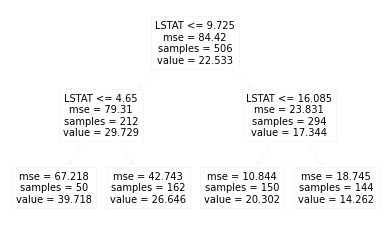

In [12]:
plot_tree(tree_model, feature_names=['LSTAT'])
plt.show()

The tree represents four intervals each one identified by each one of the leaves. Accordingly, if I use the tree to predict the output for the original input variable, I will obtain a column containing four values each one identifying one of the intervals. The intervals are identified by the values used in the decision tree for the splitting decisions, that is, 4.65, 9.725, and 16.085.

Note that, if we use the tree to predict the target value using the input variable (LSTAT) this will produce a vector containing the 4 values corresponding to the four leaves that actually identify the four intervals.

In [13]:
df['Predicted MEDV'] = np.round(tree_model.predict(df[['LSTAT']]), 2)
df['Predicted MEDV'].unique()

array([26.65, 39.72, 20.3 , 14.26])

If we check the tree, value 39.72 identifies the first interval, 26.65 identifies the second interval, 20.30 the third one, and 14.26 the fourth one. So if we want to generate an ordinal attribute for instance with 4 values we might decide to map these four values in four integers like for instance 1,2,3,4.

In [14]:
ordinal_mapping = {39.72:1,26.65:2,20.30:3,14.26:4}

In [15]:
df['Discrete LSTAT (Ordinal)'] = df['Predicted MEDV'].apply(lambda x: ordinal_mapping[x])

If we want to check how the variable LSTAT was discretized we can group by the original data using the new attribute, 

In [16]:
df[['LSTAT','Discrete LSTAT (Ordinal)']].groupby(by=['Discrete LSTAT (Ordinal)']).agg({'LSTAT':['min','max']})

LSTAT       
                            min    max
Discrete LSTAT (Ordinal)              
1                          1.73   4.63
2                          4.67   9.71
3                          9.74  16.03
4                         16.14  37.97

The values for the intervals correspond to the ones we can find in the splits inside the regression tree.

In [17]:
p = cross_val_score(LinearRegression(),df[['Discrete LSTAT (Ordinal)']], y, cv=cv)

In [18]:
print("%12s\tMean=%3.2f Std=%3.2f"%("Supervised", np.mean(p), np.std(p)))

  Supervised	Mean=0.58 Std=0.09


As can be noted the performance is slightly higher although given the high values of standard deviation the difference is probably not statistically significant.

## Discussion
There are several supervised discretization methods that have been developed. Most of them are based on information-based metrics to generate partitions that try to minimize the loss of information that discretization is likely to introduce. There are no official implementations available for scikit-learn. Some of the methods are discussed in, 
- Fayyad, Usama M.; Irani, Keki B. (1993) "Multi-Interval Discretization of Continuous-Valued Attributes for Classification Learning". https://www.ijcai.org/Proceedings/93-2/Papers/022.pdf
- Dougherty, J.; Kohavi, R. ; Sahami, M. (1995). "Supervised and Unsupervised Discretization of Continuous Features". https://ai.stanford.edu/~ronnyk/disc.pdf

There are a couple of implementations that are not integrated in scikit-learn but follow its fit/transform pattern, 
- https://github.com/navicto/Discretization-MDLPC
- https://github.com/hlin117/mdlp-discretization